In [1]:
from transformer_utils.low_memory import enable_low_memory_load
import transformers

enable_low_memory_load() #without this model ends up on CPU?
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
model = transformers.AutoModelForCausalLM.from_pretrained('gpt2')

c:\users\stephenprior\appdata\local\programs\python\python39\lib\site-packages\torch\nn\modules\lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [2]:
from src.visualization import visualize
text = "The forecast said that thunderstorm activity with the risk of hail will lead to localised"
tokens = visualize.text_to_input_ids(tokenizer, text)
expected_token_id = 17448
tokenizer.decode(expected_token_id)

' flooding'

In [3]:
targetLayer = model.transformer.h[11]
targetLayer

Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): Attention(
    (c_attn): Conv1D()
    (c_proj): Conv1D()
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): MLP(
    (c_fc): Conv1D()
    (c_proj): Conv1D()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [4]:
from captum.attr import LayerConductance

embeds = model.transformer.wte(tokens)

def forward_with_embeds(embeds):
    transformer_outputs = model.transformer.forward(inputs_embeds=embeds)
    hidden_states = transformer_outputs[0]
    lm_logits = model.lm_head(hidden_states)
    return lm_logits[0,-1,expected_token_id:expected_token_id+1]

lc=LayerConductance(forward_with_embeds, targetLayer)
embeds.requires_grad_()
attr, delta = lc.attribute(embeds,return_convergence_delta=True, attribute_to_layer_input=True)#, target=expected_token_id)
attr = attr.detach().cpu().numpy()
delta = delta.detach().cpu().numpy()

In [5]:
attr.shape, delta

((1, 17, 768), array([-70.126724], dtype=float32))

In [6]:
attr

array([[[-3.09776669e-06, -4.03615149e-06,  4.77315689e-06, ...,
         -2.09309121e-07,  2.89606783e-06, -4.85427154e-06],
        [ 1.94883483e-04, -4.45119731e-05,  6.36039622e-05, ...,
         -1.97267454e-05, -1.76732647e-04,  9.08663151e-06],
        [-2.22588118e-04, -1.84541714e-05, -4.88304795e-06, ...,
         -3.88845619e-05, -1.62111013e-04,  4.52130507e-06],
        ...,
        [-1.20859455e-04, -4.16761432e-05,  1.54259018e-04, ...,
          6.36365381e-04, -1.20745617e-05,  6.40136641e-05],
        [-1.73435299e-04,  5.84154441e-05, -7.34827481e-05, ...,
          5.81028115e-04, -8.10706570e-06,  1.29116743e-04],
        [-1.58331962e-03,  4.59101029e-05, -1.07776409e-03, ...,
          8.53463914e-03,  7.73783948e-04,  1.83526310e-03]]],
      dtype=float32)

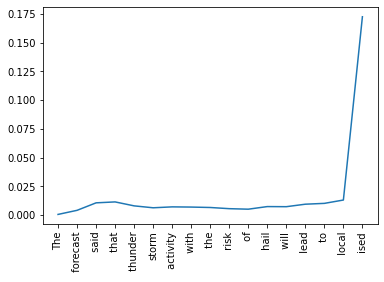

In [7]:
labels = [tokenizer.decode(token) for token in tokens[0]]

plt = visualize.plot_attribution_against_token(attr, labels )
plt.show()

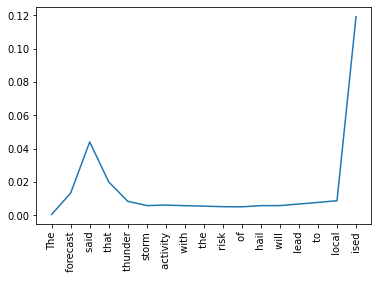

In [8]:
embeds = model.transformer.wte(tokens)
lc=LayerConductance(forward_with_embeds, model.transformer.h[10])
embeds.requires_grad_()
attr, delta = lc.attribute(embeds,return_convergence_delta=True, attribute_to_layer_input=True)#, target=expected_token_id)
attr = attr.detach().cpu().numpy()
delta = delta.detach().cpu().numpy()
plt = visualize.plot_attribution_against_token(attr, labels )
plt.show()

In [9]:
embeds = model.transformer.wte(tokens)
lc=
embeds.requires_grad_()
attr, delta = lc.attribute(embeds,return_convergence_delta=True, attribute_to_layer_input=True)#, target=expected_token_id)
attr = attr.detach().cpu().numpy()
delta = delta.detach().cpu().numpy()
plt = visualize.plot_attribution_against_token(attr, labels )
plt.show()

SyntaxError: invalid syntax (<ipython-input-9-200574d355a7>, line 2)

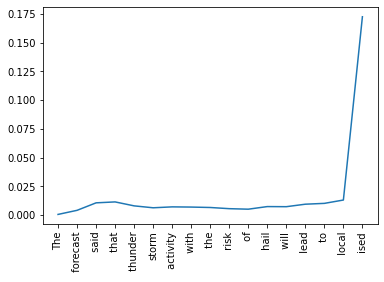

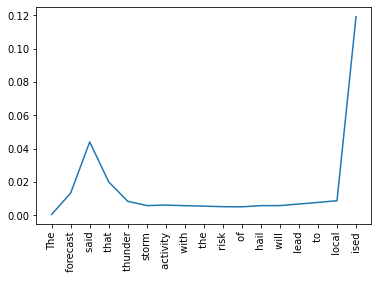

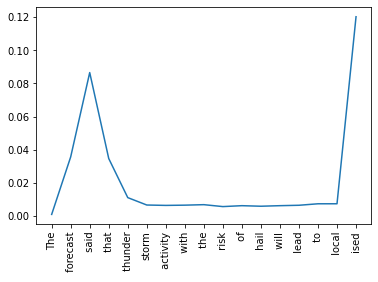

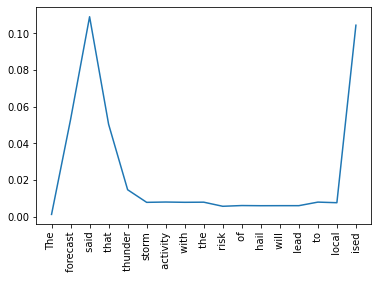

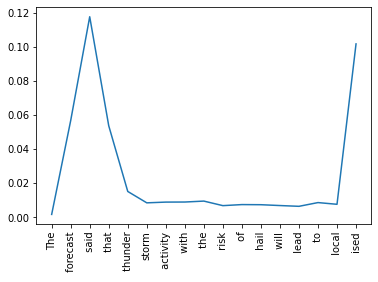

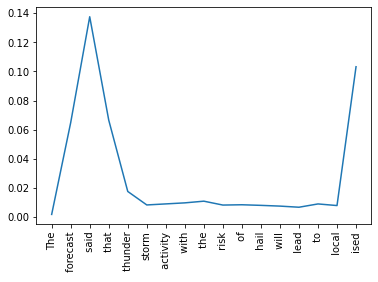

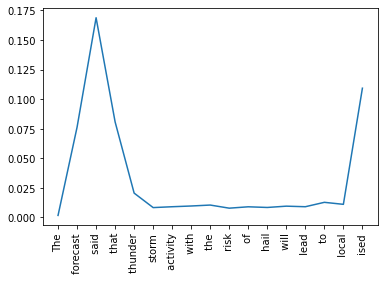

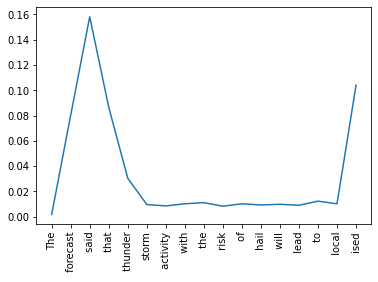

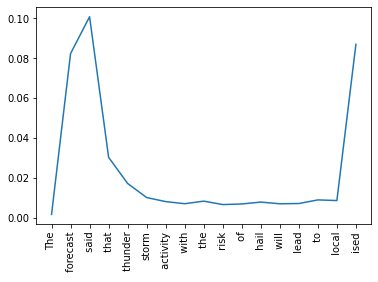

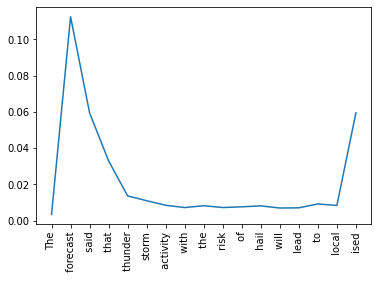

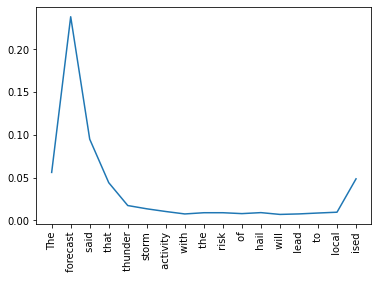

In [10]:
for i in range(11,0,-1):
    lc = LayerConductance(forward_with_embeds, model.transformer.h[i])
    plt = visualize.plot_layer_attribution(model, tokens, labels, lc)
    plt.show()